Note to self 6/4-22:
Totalt antall stemmer godt med PSAK120.
Alt med DP stemmer bra med excel, men ikke så bra med PSAK120.
Automatisk stemmer så bra at autograd blir det samme på figur 1, men litt unøyaktighet her også.


For the future 22/4-22:
Når vi joiner med `PEN.T_SKJEMA` forsvinner (nesten) alle ikke-selvbetjente saker. Teste ut andre typer join for å konservere antall saker. Hvordan håndtere resulterende nullverdier fra `PEN.T_SKJEMA`?
Kan være nødvendig å se mer på `OPPRETTET_AV`; mye der som kommer fra batch.

In [125]:
import cx_Oracle
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from google.cloud import secretmanager

ModuleNotFoundError: No module named 'pandas_utils'

In [126]:
secrets = secretmanager.SecretManagerServiceClient()
resource_name = f"projects/knada-gcp/secrets/vebjorns-hemmelighet/versions/latest"
secret = secrets.access_secret_version(name=resource_name)
secrets = dict([line.split("=") for line in secret.payload.data.decode('UTF-8').splitlines()])

ORACLE_HOST = '10.53.136.15'
ORACLE_PORT = '1521'
ORACLE_SERVICE = 'pen'

In [127]:
dsnStr = cx_Oracle.makedsn(ORACLE_HOST, ORACLE_PORT, service_name=ORACLE_SERVICE)

In [ ]:
con = cx_Oracle.connect(user=secrets["PEN_USER"], password=secrets["PEN_PASSWORD"],
                               dsn=dsnStr)

In [106]:
def pandas_from_sql(filename: str, con=con):
    with open(filename, 'r') as file:
        query = file.read()
    return pd.read_sql(query, con=con)

In [107]:
df_total = pandas_from_sql('../sql/Forstegangskrav_mnd.sql', con)

In [108]:
df_dp_tot = pandas_from_sql('../sql/Forstegangskrav_AP_DP.sql', con)

In [109]:
df_autograd_dp = pandas_from_sql('../sql/Autograd_DP.sql', con)

In [110]:
test = pandas_from_sql('../sql/AutoSelv.sql', con)

In [111]:
con.close()

In [112]:
def get_dp_behandling(df, behandling):
    return df[df["K_BEHANDLING_T"] == behandling]

In [113]:
df_dp_tot.tail(16)

,ÅR,MÅNED,ANTALL
145,2021,1,4475
146,2021,2,3843
147,2021,3,3720
148,2021,4,3945
149,2021,5,3655
150,2021,6,3587
151,2021,7,2547
152,2021,8,3360
153,2021,9,3976
154,2021,10,3540


In [115]:
df_total.head(12)

,ÅR,MÅNED,ANTALL
0,2008,12,601
1,2009,1,1728
2,2009,2,5655
3,2009,3,4305
4,2009,4,4157
5,2009,5,4801
6,2009,6,5293
7,2009,7,5584
8,2009,8,4229
9,2009,9,4104


In [116]:
df = df_dp_tot.copy()
# Rename columns
df.columns = ["ÅR", "MÅNED", "DP_TOT"]
# Add "ÅR-MÅNED" TO FRONT
df["ÅR-MÅNED"] = df[["ÅR", "MÅNED"]].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
cols = list(df.columns.values)
cols.insert(0, cols.pop())
df = df[cols]

In [117]:
# Førstegangskrav totalt minus krav som er opprettet i forbindelse med alderskonvertering
# Stemmer mot PSAK120
df["TOTALT"] = df_total["ANTALL"]

df["AUTO"] = get_dp_behandling(df_autograd_dp, "AUTO")["ANTALL"].reset_index(drop=True)
df["MAN"] = get_dp_behandling(df_autograd_dp, "MAN")["ANTALL"].reset_index(drop=True)

# "DEL_AUTO" is missing from some months ==> indexes don't match (need to merge on month)
tmp = get_dp_behandling(df_autograd_dp, "DEL_AUTO")[["ANTALL", "ÅR", "MÅNED"]]
df["DEL_AUTO"] = df.merge(tmp, how="left", left_on=["ÅR", "MÅNED"], right_on=["ÅR", "MÅNED"])["ANTALL"].fillna(0).astype(int)

df["DP_AUTOGRAD"] = df["AUTO"]/df["DP_TOT"]
df["AUTOGRAD"] = df["AUTO"]/df["TOTALT"]
df["AUTOGRAD_PROSENT"] = df["AUTOGRAD"].apply(lambda x: round(x*100, 0)).astype(int).astype(str) + '%'

In [118]:
df.tail(16)

,ÅR-MÅNED,ÅR,MÅNED,DP_TOT,TOTALT,AUTO,MAN,DEL_AUTO,DP_AUTOGRAD,AUTOGRAD,AUTOGRAD_PROSENT
145,2021-1,2021,1,4475,5292,2605,1472,398,0.582123,0.492252,49%
146,2021-2,2021,2,3843,4711,2339,1130,374,0.608639,0.496498,50%
147,2021-3,2021,3,3720,4644,2264,1161,295,0.608602,0.487511,49%
148,2021-4,2021,4,3945,4772,2393,1262,290,0.606591,0.501467,50%
149,2021-5,2021,5,3655,4371,2152,1183,320,0.588782,0.492336,49%
150,2021-6,2021,6,3587,4541,2148,1102,337,0.598829,0.473024,47%
151,2021-7,2021,7,2547,3197,1514,794,239,0.594425,0.473569,47%
152,2021-8,2021,8,3360,4083,2002,1050,308,0.595833,0.490326,49%
153,2021-9,2021,9,3976,4795,2398,1219,359,0.603119,0.500104,50%
154,2021-10,2021,10,3540,4479,2054,1190,296,0.580226,0.458585,46%


In [119]:
nav_colors = (
    "#0067C5",
    "#BA3A26",
    "#06893A",
    "#634689",
    "#FF9100",
    "#66CBEC",
    "#F0C419",
)
pastel = px.colors.qualitative.Pastel

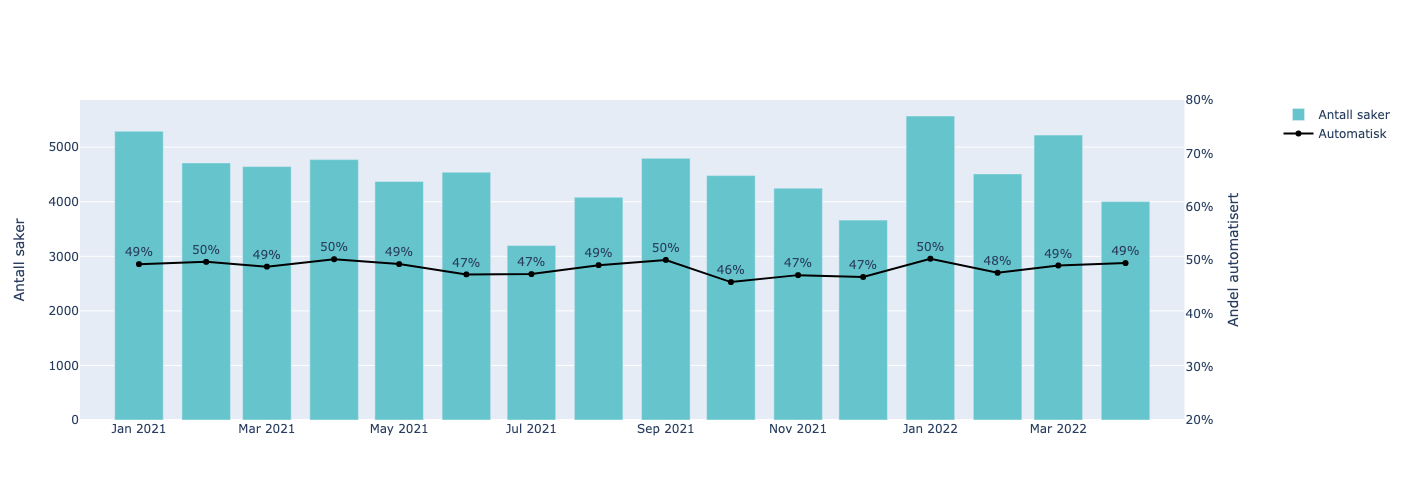

In [120]:
n_months = 16

df_plot = df.iloc[-n_months:,:]

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=df_plot["ÅR-MÅNED"], y=df_plot["TOTALT"], marker_color=pastel[0], name="Antall saker"), secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot["ÅR-MÅNED"], y=df_plot["AUTOGRAD"], text=df_plot["AUTOGRAD_PROSENT"], mode='lines+markers+text', marker_color="black", name="Automatisk", textposition='top center'), secondary_y=True)
#fig.add_trace(go.Scatter(x=df_plot["ÅR-MÅNED"], y=df_plot["DP_AUTOGRAD"], marker_color=pastel[2], name="Automatisk DP"), secondary_y=True)
fig.update_yaxes(title_text="Andel automatisert", secondary_y=True, range=[0.2,0.8], tickformat='.0%')
fig.update_yaxes(title_text="Antall saker", secondary_y=False)
fig.layout.yaxis2.showgrid = False
fig.update_layout(
    autosize=False,
    width=1300,
    height=500,)

In [121]:
test.tail(20)

,ÅR,MÅNED,OPPRETTET_AV,AUTOMATISERING,ANTALL
28,2021,8,bruker,AUTO,1970
29,2021,8,bruker,MAN,1348
30,2021,8,saksbehandler,AUTO,32
31,2021,8,saksbehandler,MAN,733
32,2021,9,bruker,AUTO,2344
33,2021,9,bruker,MAN,1563
34,2021,9,saksbehandler,AUTO,54
35,2021,9,saksbehandler,MAN,834
36,2021,10,bruker,AUTO,2024
37,2021,10,bruker,MAN,1481


In [122]:
from datastory import DataStory

In [123]:
ds = DataStory(f"Automatiserings- og selvbetjeningsgrad for alderspensjon")

ds.markdown("**(Under utvikling)**")
ds.markdown(f"Automatisering av førstegangsbehandlingssaker for alderspensjon i pesys. Saker opprettet av batch er eksludert.")
ds.plotly(fig.to_json())

In [ ]:
#ds.publish(url="https://nada.intern.nav.no/api") #prod